# Exp 147 analysis

See `./informercial/Makefile` for experimental
details.

In [1]:
import os
import numpy as np

from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('ticks')

matplotlib.rcParams.update({'font.size': 16})
matplotlib.rc('axes', titlesize=16)

from infomercial.exp import meta_bandit
from infomercial.exp import epsilon_bandit
from infomercial.exp import beta_bandit
from infomercial.exp import softbeta_bandit
from infomercial.local_gym import bandit
from infomercial.exp.meta_bandit import load_checkpoint

import gym

In [2]:
def plot_meta(env_name, result):
    """Plots!"""
    
    # episodes, actions, scores_E, scores_R, values_E, values_R, ties, policies
    episodes = result["episodes"]
    actions =result["actions"]
    bests =result["p_bests"]
    scores_E = result["scores_E"]
    scores_R = result["scores_R"]
    values_R = result["values_R"]
    values_E = result["values_E"]
    ties = result["ties"]
    policies = result["policies"]
    
    # -
    env = gym.make(env_name)
    best = env.env.best
    print(f"Best arm: {best}, last arm: {actions[-1]}")

    # Plotz
    fig = plt.figure(figsize=(6, 14))
    grid = plt.GridSpec(6, 1, wspace=0.3, hspace=0.8)

    # Arm
    plt.subplot(grid[0, 0])
    plt.scatter(episodes, actions, color="black", alpha=.5, s=2, label="Bandit")
    plt.plot(episodes, np.repeat(best, np.max(episodes)+1), 
             color="red", alpha=0.8, ls='--', linewidth=2)
    plt.ylim(-.1, np.max(actions)+1.1)
    plt.ylabel("Arm choice")
    plt.xlabel("Episode")

    # Policy
    policies = np.asarray(policies)
    episodes = np.asarray(episodes)
    plt.subplot(grid[1, 0])
    m = policies == 0
    plt.scatter(episodes[m], policies[m], alpha=.4, s=2, label="$\pi_E$", color="purple")
    m = policies == 1
    plt.scatter(episodes[m], policies[m], alpha=.4, s=2, label="$\pi_R$", color="grey")
    plt.ylim(-.1, 1+.1)
    plt.ylabel("Controlling\npolicy")
    plt.xlabel("Episode")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()
    
    # score
    plt.subplot(grid[2, 0])
    plt.scatter(episodes, scores_E, color="purple", alpha=0.4, s=2, label="E")
    plt.plot(episodes, scores_E, color="purple", alpha=0.4)
    plt.scatter(episodes, scores_R, color="grey", alpha=0.4, s=2, label="R")
    plt.plot(episodes, scores_R, color="grey", alpha=0.4)
    plt.plot(episodes, np.repeat(tie_threshold, np.max(episodes)+1), 
             color="violet", alpha=0.8, ls='--', linewidth=2)
    plt.ylabel("Score")
    plt.xlabel("Episode")
#     plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    # Q
    plt.subplot(grid[3, 0])
    plt.scatter(episodes, values_E, color="purple", alpha=0.4, s=2, label="$Q_E$")
    plt.scatter(episodes, values_R, color="grey", alpha=0.4, s=2, label="$Q_R$")
    plt.plot(episodes, np.repeat(tie_threshold, np.max(episodes)+1), 
             color="violet", alpha=0.8, ls='--', linewidth=2)
    plt.ylabel("Value")
    plt.xlabel("Episode")
#     plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    
    # Ties
    plt.subplot(grid[4, 0])
    plt.scatter(episodes, bests, color="red", alpha=.5, s=2)
    plt.ylabel("p(best)")
    plt.xlabel("Episode")
    plt.ylim(0, 1)

    # Ties
    plt.subplot(grid[5, 0])
    plt.scatter(episodes, ties, color="black", alpha=.5, s=2, label="$\pi_{tie}$ : 1\n $\pi_\pi$ : 0")
    plt.ylim(-.1, 1+.1)
    plt.ylabel("Ties index")
    plt.xlabel("Episode")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    
def plot_epsilon(env_name, result):
    """Plots!"""
    
    # episodes, actions, scores_E, scores_R, values_E, values_R, ties, policies
    episodes = result["episodes"]
    actions =result["actions"]
    bests =result["p_bests"]
    scores_R = result["scores_R"]
    values_R = result["values_R"]
    epsilons = result["epsilons"]
    
    # -
    env = gym.make(env_name)
    best = env.env.best
    print(f"Best arm: {best}, last arm: {actions[-1]}")

    # Plotz
    fig = plt.figure(figsize=(6, 14))
    grid = plt.GridSpec(6, 1, wspace=0.3, hspace=0.8)

    # Arm
    plt.subplot(grid[0, 0])
    plt.scatter(episodes, actions, color="black", alpha=.5, s=2, label="Bandit")
    for b in best:
        plt.plot(episodes, np.repeat(b, np.max(episodes)+1), 
                 color="red", alpha=0.8, ls='--', linewidth=2)
    plt.ylim(-.1, np.max(actions)+1.1)
    plt.ylabel("Arm choice")
    plt.xlabel("Episode")

    # score
    plt.subplot(grid[1, 0])
    plt.scatter(episodes, scores_R, color="grey", alpha=0.4, s=2, label="R")
    plt.ylabel("Score")
    plt.xlabel("Episode")
#     plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    # Q
    plt.subplot(grid[2, 0])
    plt.scatter(episodes, values_R, color="grey", alpha=0.4, s=2, label="$Q_R$")
    plt.ylabel("Value")
    plt.xlabel("Episode")
#     plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    # best
    plt.subplot(grid[3, 0])
    plt.scatter(episodes, bests, color="red", alpha=.5, s=2)
    plt.ylabel("p(best)")
    plt.xlabel("Episode")
    plt.ylim(0, 1)

    # Decay
    plt.subplot(grid[4, 0])
    plt.scatter(episodes, epsilons, color="black", alpha=.5, s=2)
    plt.ylabel("$\epsilon_R$")
    plt.xlabel("Episode")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
def plot_critic(critic_name, env_name, result):
    # -
    env = gym.make(env_name)
    best = env.env.best
    
    # Data
    critic = result[critic_name]
    arms = list(critic.keys())
    values = list(critic.values())

    # Plotz
    fig = plt.figure(figsize=(8, 3))
    grid = plt.GridSpec(1, 1, wspace=0.3, hspace=0.8)

    # Arm
    plt.subplot(grid[0])
    plt.scatter(arms, values, color="black", alpha=.5, s=30)
    plt.plot([best]*10, np.linspace(min(values), max(values), 10), color="red", alpha=0.8, ls='--', linewidth=2)
    plt.ylabel("Value")
    plt.xlabel("Arm")

# Load and process data

In [3]:
data_path ="/Users/qualia/Code/infomercial/data/"
exp_name = "exp147"
sorted_params = load_checkpoint(os.path.join(data_path, f"{exp_name}_sorted.pkl"))

In [4]:
# print(sorted_params.keys())
best_params = sorted_params[0]
sorted_params

{0: {'epsilon': 0.7666645365811449,
  'epsilon_decay_tau': 0.014058030361594634,
  'lr_R': 7.504905974098415e-05,
  'total_R': 1029.0},
 1: {'epsilon': 0.7994755945597659,
  'epsilon_decay_tau': 0.09680111804211074,
  'lr_R': 0.00012737665030134113,
  'total_R': 1017.0},
 2: {'epsilon': 0.5929692956398341,
  'epsilon_decay_tau': 0.06601793307735285,
  'lr_R': 0.0004125231471865629,
  'total_R': 1016.0},
 3: {'epsilon': 0.7157300765222281,
  'epsilon_decay_tau': 0.0017946495652407003,
  'lr_R': 0.0002246187393893176,
  'total_R': 1015.0},
 4: {'epsilon': 0.8106952364231761,
  'epsilon_decay_tau': 0.027726346713680766,
  'lr_R': 0.0002015437124307451,
  'total_R': 1000.0},
 5: {'epsilon': 0.7644577366785992,
  'epsilon_decay_tau': 0.012801284417407082,
  'lr_R': 0.0003405605208724825,
  'total_R': 987.0},
 6: {'epsilon': 0.7349371466904244,
  'epsilon_decay_tau': 0.01639047106110835,
  'lr_R': 0.00018076527678513016,
  'total_R': 948.0},
 7: {'epsilon': 0.42575903983755486,
  'epsilon_de

# Performance

of best parameters

{'epsilon': 0.7666645365811449, 'epsilon_decay_tau': 0.014058030361594634, 'lr_R': 7.504905974098415e-05, 'total_R': 1029.0}
Best arm: [7], last arm: 3


No handles with labels found to put in legend.


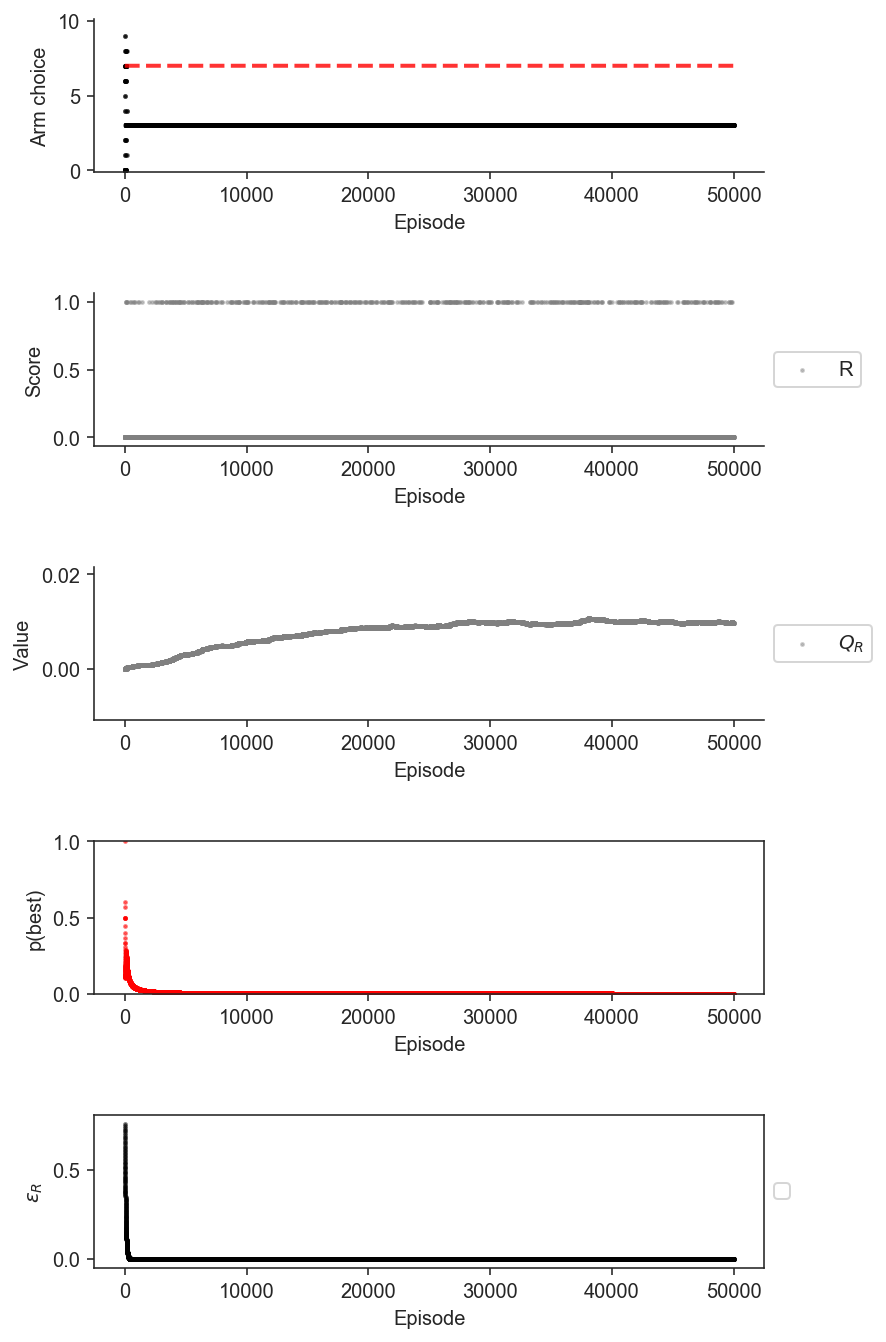

In [14]:
env_name = 'BanditHardAndSparse10-v0'
num_episodes = 50000

# Run w/ best params
result = epsilon_bandit(
    env_name=env_name,
    num_episodes=num_episodes, 
    lr_R=best_params["lr_R"],
    epsilon=best_params["epsilon"],
    epsilon_decay_tau=best_params["epsilon_decay_tau"],
    seed_value=336,
)

print(best_params)
plot_epsilon(env_name, result=result)

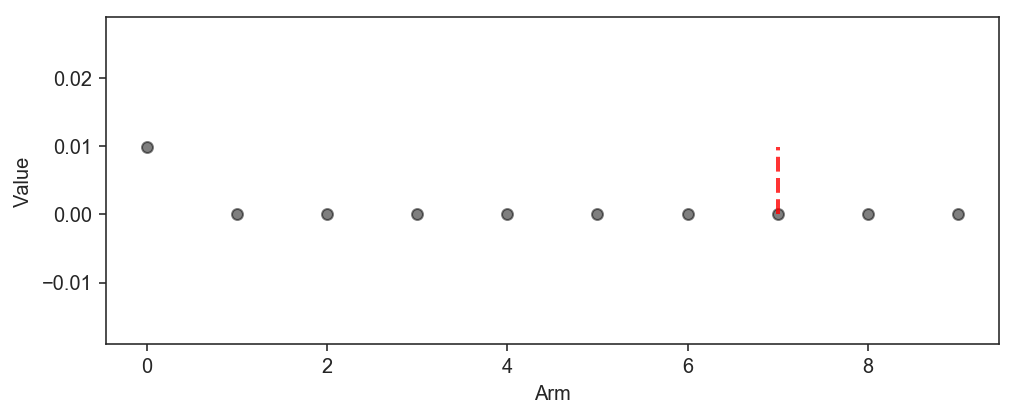

In [7]:
plot_critic('critic_R', env_name, result)

# Sensitivity

to parameter choices

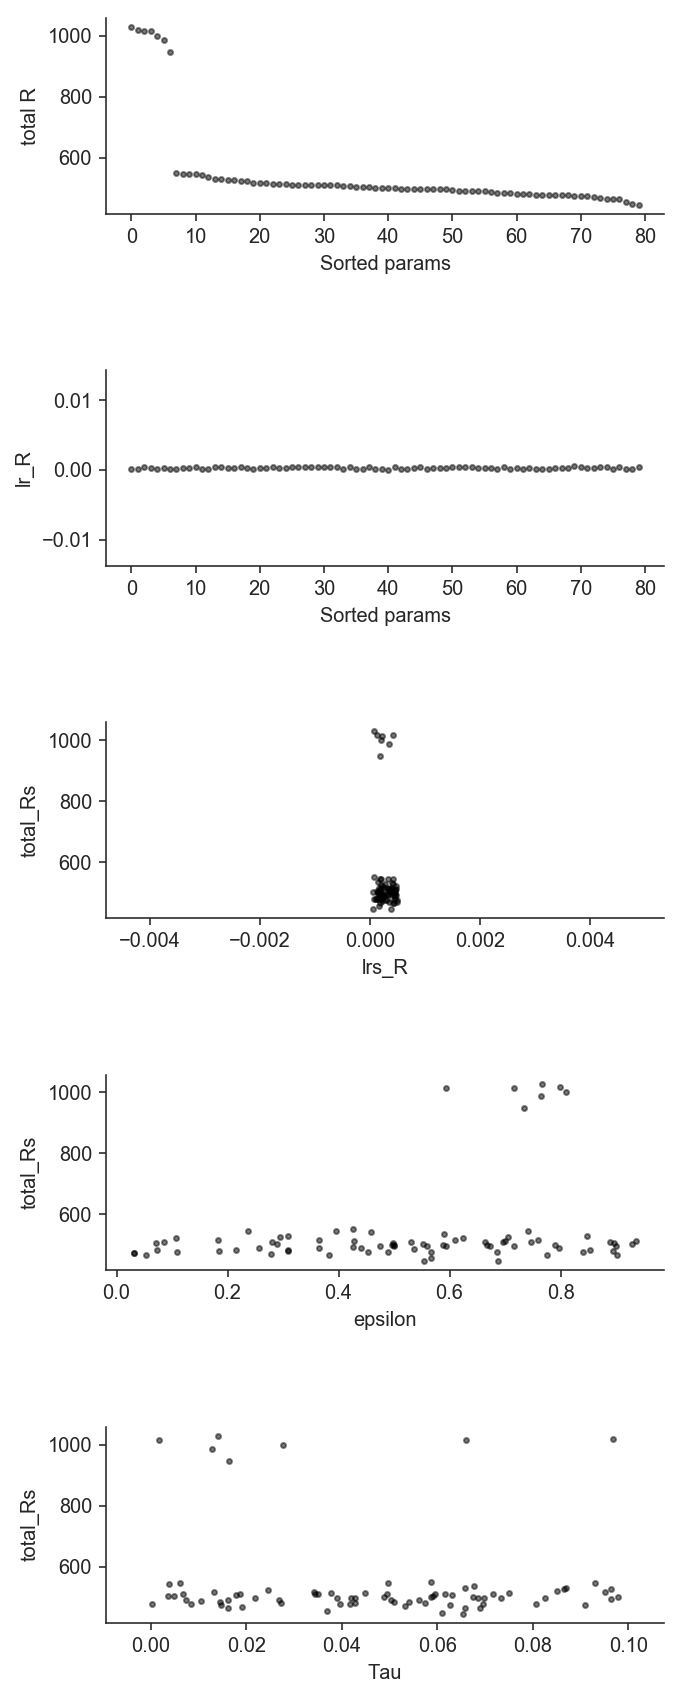

In [8]:
total_Rs = [] 
eps = []
lrs_R = []
lrs_E = []
decays = []
trials = list(sorted_params.keys())
for t in trials:
    total_Rs.append(sorted_params[t]['total_R'])
    lrs_R.append(sorted_params[t]['lr_R'])
    eps.append(sorted_params[t]['epsilon'])
    decays.append(sorted_params[t]['epsilon_decay_tau'])
    
# Init plot
fig = plt.figure(figsize=(5, 18))
grid = plt.GridSpec(6, 1, wspace=0.3, hspace=0.8)

# Do plots:
# Arm
plt.subplot(grid[0, 0])
plt.scatter(trials, total_Rs, color="black", alpha=.5, s=6, label="total R")
plt.xlabel("Sorted params")
plt.ylabel("total R")
_ = sns.despine()


plt.subplot(grid[1, 0])
plt.scatter(trials, lrs_R, color="black", alpha=.5, s=6, label="total R")
plt.xlabel("Sorted params")
plt.ylabel("lr_R")
_ = sns.despine()

plt.subplot(grid[2, 0])
plt.scatter(lrs_R, total_Rs, color="black", alpha=.5, s=6, label="total R")
plt.xlabel("lrs_R")
plt.ylabel("total_Rs")
_ = sns.despine()

plt.subplot(grid[3, 0])
plt.scatter(eps, total_Rs, color="black", alpha=.5, s=6, label="total R")
plt.xlabel("epsilon")
plt.ylabel("total_Rs")
_ = sns.despine()

plt.subplot(grid[4, 0])
plt.scatter(decays, total_Rs, color="black", alpha=.5, s=6, label="total R")
plt.xlabel("Tau")
plt.ylabel("total_Rs")
_ = sns.despine()

# Parameter correlations

In [9]:
from scipy.stats import spearmanr
spearmanr(eps, lrs_R)

SpearmanrResult(correlation=-0.11872948898265355, pvalue=0.2942006490131173)

In [10]:
spearmanr(eps, total_Rs)

SpearmanrResult(correlation=0.18450176357086748, pvalue=0.10134657015070979)

In [11]:
spearmanr(lrs_R, total_Rs)

SpearmanrResult(correlation=-0.04220398709207796, pvalue=0.7101098321449335)

# Distributions

of parameters

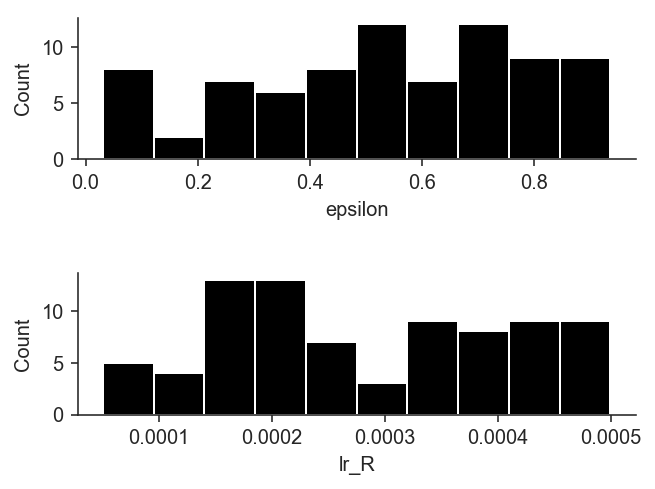

In [12]:
# Init plot
fig = plt.figure(figsize=(5, 6))
grid = plt.GridSpec(3, 1, wspace=0.3, hspace=0.8)

plt.subplot(grid[0, 0])
plt.hist(eps, color="black")
plt.xlabel("epsilon")
plt.ylabel("Count")
_ = sns.despine()

plt.subplot(grid[1, 0])
plt.hist(lrs_R, color="black")
plt.xlabel("lr_R")
plt.ylabel("Count")
_ = sns.despine()

of total reward

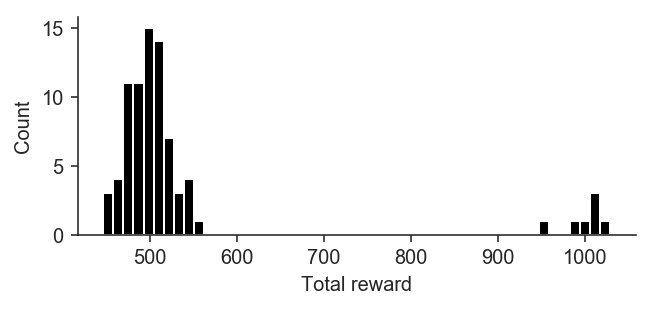

In [13]:
# Init plot
fig = plt.figure(figsize=(5, 2))
grid = plt.GridSpec(1, 1, wspace=0.3, hspace=0.8)

plt.subplot(grid[0, 0])
plt.hist(total_Rs, color="black", bins=50)
plt.xlabel("Total reward")
plt.ylabel("Count")
# plt.xlim(0, 10)
_ = sns.despine()